In [1]:
import json
import numpy as np
from typing import Optional
from pathlib import Path
from matplotlib import pyplot as plt
from Regression import *

In [2]:
def load_experiments(results_path: Path, metadata_keys: list[str]) -> list[dict]:
    experiments = {}
    for i in range(506, 1000):
        try:
            experiment_path = results_path / f'experiment_{i}.json'
            experiment_file = open(experiment_path, 'r')
            experiment = json.load(experiment_file)

            metadata_path = results_path / f'experiment_{i}_metadata.json'
            metadata_file = open(metadata_path, 'r')
            metadata = json.load(metadata_file)
            metadata['key'] = i

            _dict = experiments
            for key in metadata_keys[:-1]:
                value = metadata.get(key, None)
                _dict = _dict.setdefault((key, value), {})
            key = metadata_keys[-1]
            value = metadata.get(key, None)
            _dict.setdefault((key, value), list(experiment.items())) 
        except FileNotFoundError:
            break
    return experiments

In [3]:
results_path = Path('../../results')
metadata_keys = [
    'language',
    'key',
    'name',
    'shots',
    'qfa size',
    'qiskit circuit size',
    'simulator',
    'mimic_rate_gate',
    'mimic_rate_readout',
    'use_entropy_mapping',
    'use_mapping_noise_correction'
]
experiments = load_experiments(results_path, metadata_keys)
print(metadata_keys)
print(experiments)

['language', 'key', 'name', 'shots', 'qfa size', 'qiskit circuit size', 'simulator', 'mimic_rate_gate', 'mimic_rate_readout', 'use_entropy_mapping', 'use_mapping_noise_correction']
{('language', 'mod_3'): {('key', 506): {('name', 'mapping effect, change QFA state number'): {('shots', 100000): {('qfa size', 10): {('qiskit circuit size', 4): {('simulator', True): {('mimic_rate_gate', 0.01): {('mimic_rate_readout', 0.01): {('use_entropy_mapping', False): {('use_mapping_noise_correction', False): [('11', {'observed': [0.26987, 0.71288], 'expected': [0.24999999999999994, 0.75], 'circuit': {'rz': 809, 'sx': 544, 'cx': 282, 'measure': 4, 'barrier': 1}}), ('111', {'observed': [0.91364, 0.063], 'expected': [1.0, 0.0], 'circuit': {'rz': 1035, 'sx': 698, 'cx': 373, 'measure': 4, 'barrier': 1}}), ('1111', {'observed': [0.281, 0.69109], 'expected': [0.2500000000000003, 0.7499999999999998], 'circuit': {'rz': 1261, 'sx': 852, 'cx': 464, 'measure': 4, 'barrier': 1}}), ('11111', {'observed': [0.2871, 0

In [4]:
def iterate_nested_dict(d: dict, keys: Optional[list[tuple]] = None):
    if keys is None:
        keys = []
    for k, v in d.items():
        if isinstance(v, dict):
            yield from iterate_nested_dict(v, keys+[k])
        else:
            yield {k_: v for k_, v in (keys+[k])}, v

def get_from_nested_dict(d: dict, keys: dict):
    for key in keys.items():
        if key not in d:
            return None
        d = d[key]
    return d

In [13]:
def draw_line_plot(_experiment: list[tuple[str, dict]], normalize: bool = False, ylim: Optional[tuple[float, float]] = (0, 1)):
    experiment = {k: v for k, v in _experiment}
    xs = np.array([len(k) for k in experiment])
    ys = np.array([v["observed"][0] for v in experiment.values()])
    zs = np.array([v["expected"][0] for v in experiment.values()])

    if normalize:
        ys /= np.array([sum(v["observed"]) for v in experiment.values()])

    length_weight = 0
    total = 0
    for i, x in enumerate(xs):
        if x <= 1 or x>20:
            continue
        length_weight += 1/x
        accept_rate = ys[i]/zs[i]
        if ys[i]==1 or zs[i]==1:
            total += accept_rate/x
        else:
            reject_rate = (1-ys[i])/(1-zs[i])
            total += min(accept_rate, reject_rate)/x
    print(total/length_weight)
    print(MAPE(zs, ys))

    width = 0.3
    # plt.bar(xs, ys, width=width, label="observed")
    # plt.bar(xs+width, zs, width=width, label="expected")
    plt.plot(xs, ys, label="observed", marker='o')
    plt.plot(xs, zs, label="expected", marker='s')
    if ylim != None:
        plt.ylim(*ylim)
    plt.legend()
    plt.xticks(xs)
    plt.show()

In [6]:
def draw_scatter_plot(_experiment: list[tuple[str, dict]], normalize: bool = False, ylim: Optional[tuple[float, float]] = (0, 1)):
    experiment = {k: v for k, v in _experiment}
    xs = np.array([len(k) for k in experiment])
    ys = np.array([v["observed"][0] for v in experiment.values()])
    zs = np.array([v["expected"][0] for v in experiment.values()])

    if normalize:
        ys /= np.array([sum(v["observed"]) for v in experiment.values()])

    

    length_weight = 0
    total = 0
    for i, x in enumerate(xs):
        if x <= 1 or x>20:
            continue
        length_weight += 1/x
        accept_rate = ys[i]/zs[i]
        if ys[i]==1 or zs[i]==1:
            total += accept_rate/x
        else:
            reject_rate = (1-ys[i])/(1-zs[i])
            total += min(accept_rate, reject_rate)/x
    print(total/length_weight)

    width = 0.3
    # plt.bar(xs, ys, width=width, label="observed")
    # plt.bar(xs+width, zs, width=width, label="expected")
    plt.plot(xs, ys, label="observed", marker='o')
    plt.plot(xs, zs, label="expected", marker='s')
    if ylim != None:
        plt.ylim(*ylim)
    plt.legend()
    plt.xticks(xs)
    plt.show()

In [7]:
def draw_comparison_plot(
    experiment1: list[tuple[str, dict]],
    experiment2: list[tuple[str, dict]],
    labels: tuple[str, str] = ("", ""),
    normalize: bool = False
) -> None:
    _experiment1 = {k: v for k, v in experiment1}
    _experiment2 = {k: v for k, v in experiment2}
    xs = np.array([len(k) for k in _experiment1])
    y1s = np.array([v["observed"][0] for v in _experiment1.values()])
    y2s = np.array([v["observed"][0] for v in _experiment2.values()])
    zs = np.array([v["expected"][0] for v in _experiment1.values()])

    if normalize:
        y1s /= np.array([sum(v["observed"]) for v in _experiment1.values()])
        y2s /= np.array([sum(v["observed"]) for v in _experiment2.values()])
        

    width = 0.3
    # plt.bar(xs, ys, width=width, label="observed")
    # plt.bar(xs+width, zs, width=width, label="expected")
    plt.plot(xs, y1s, label=labels[0], marker='o')
    plt.plot(xs, y2s, label=labels[1], marker='s')
    plt.plot(xs, zs, label="expected", linestyle='--')
    plt.legend()
    plt.xticks(xs)
    plt.show()

In [10]:
for i, (k, experiment) in enumerate(iterate_nested_dict(experiments)):
    break
    print(k)
    # if k['use_entropy_mapping']:
    #     continue
    # k_ = k.copy()
    # k_['use_entropy_mapping'] = True
    # experiment2 = get_from_nested_dict(experiments, k_)
    # print(k_)
    draw_line_plot(experiment, True)

0 {'language': 'mod_3', 'key': 506, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 10, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.9099438066010012
33.58425641025639


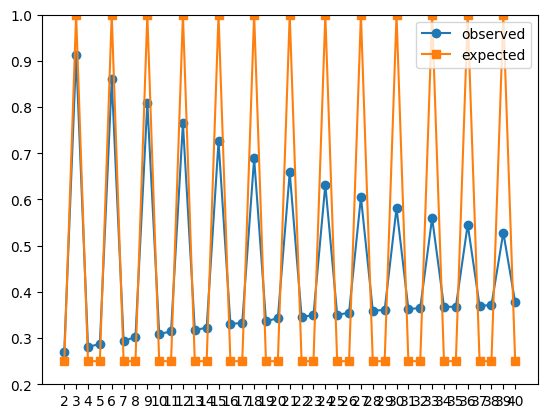

1 {'language': 'mod_3', 'key': 507, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 10, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.9227166593944333
21.448897435897415


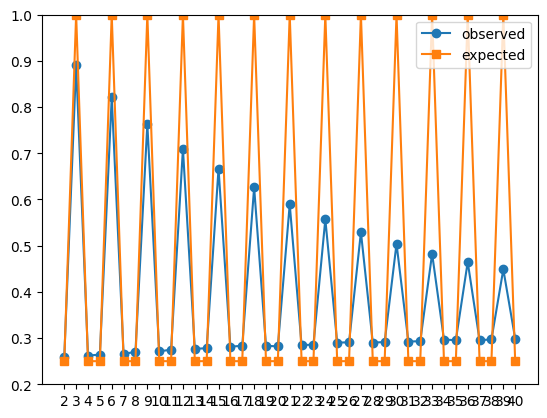

18 {'language': 'mod_3', 'key': 524, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 12, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.9050991057900426
36.960871794871736


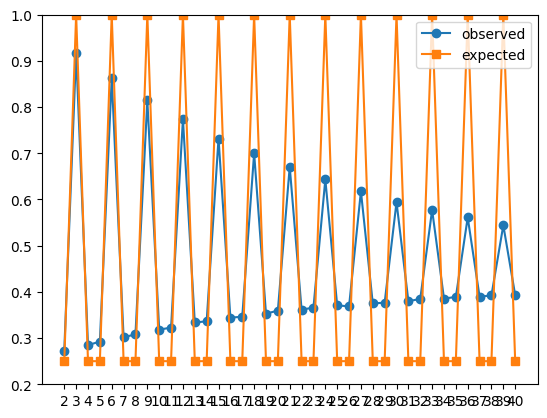

19 {'language': 'mod_3', 'key': 525, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 12, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.9188686427902533
27.620153846153794


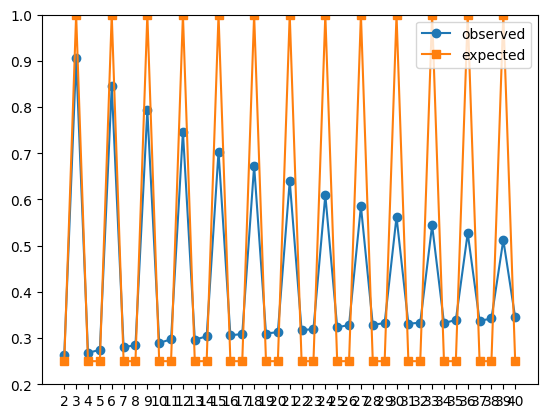

36 {'language': 'mod_3', 'key': 542, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 14, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.8907965412994278
42.72202564102561


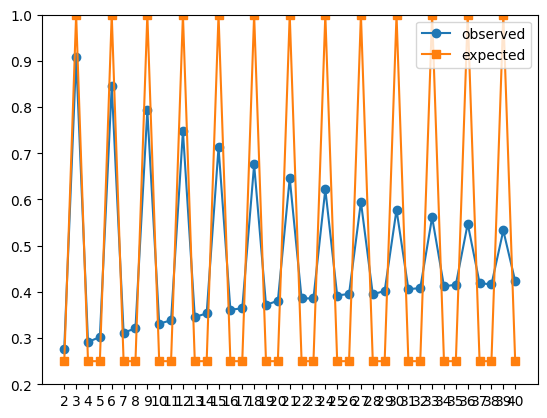

37 {'language': 'mod_3', 'key': 543, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 14, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.915889946844554
32.69730769230767


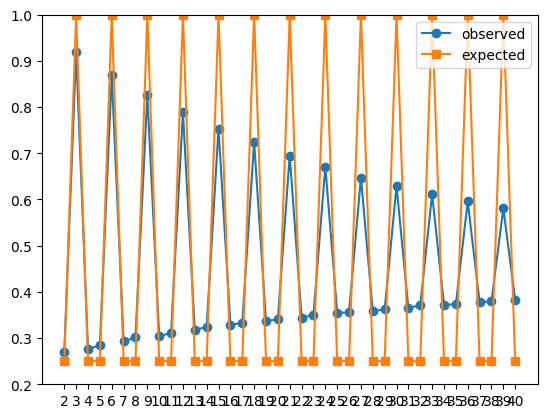

54 {'language': 'mod_3', 'key': 560, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 16, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.8830270013806472
49.138794871794786


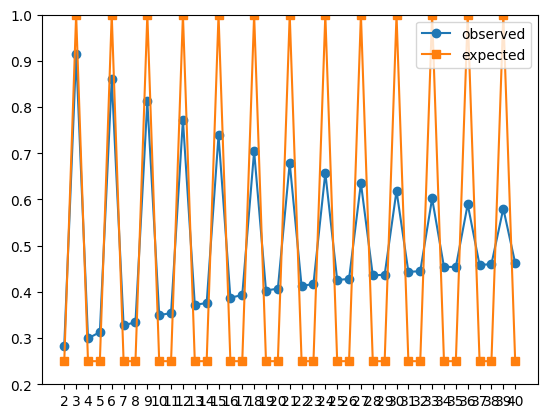

55 {'language': 'mod_3', 'key': 561, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 16, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.9202694180513094
36.5105384615384


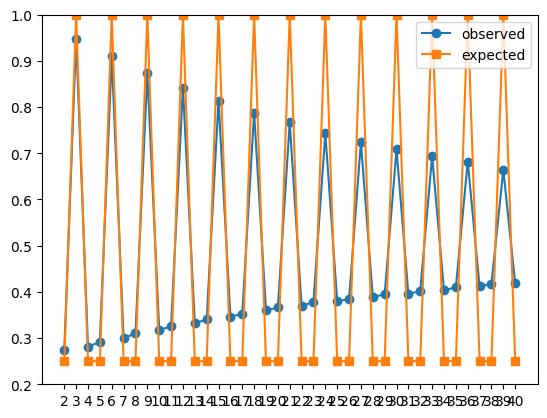

72 {'language': 'mod_3', 'key': 578, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.7863791021138508
55.4477692307692


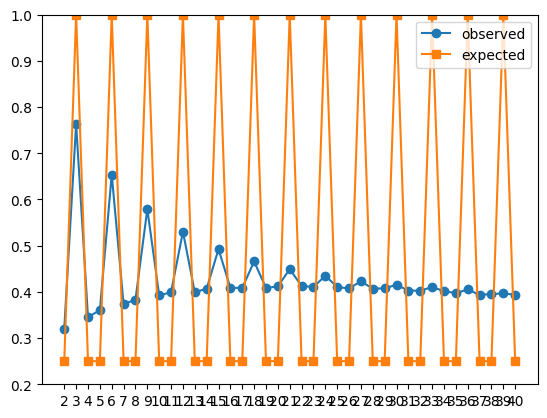

73 {'language': 'mod_3', 'key': 579, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8452140018035187
26.901153846153825


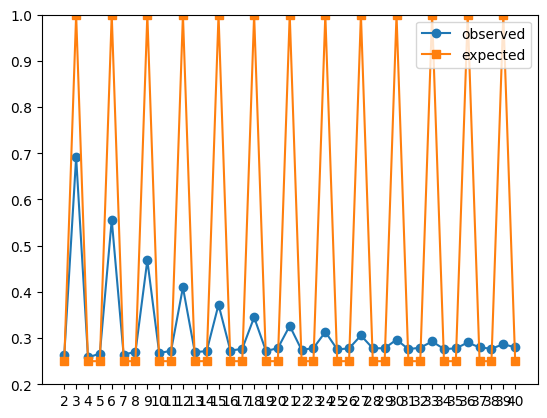

90 {'language': 'mod_3', 'key': 596, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 20, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.7858859609940039
55.89507692307689


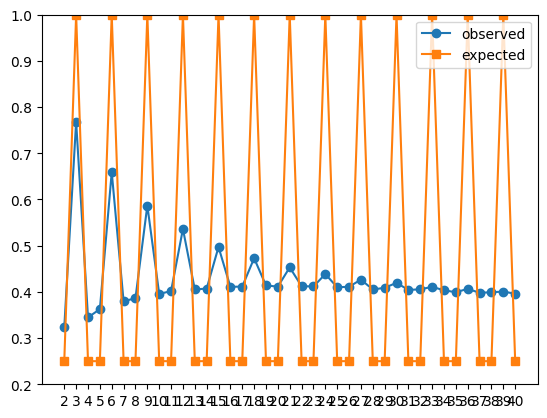

91 {'language': 'mod_3', 'key': 597, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 20, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8341693762162535
32.90533333333331


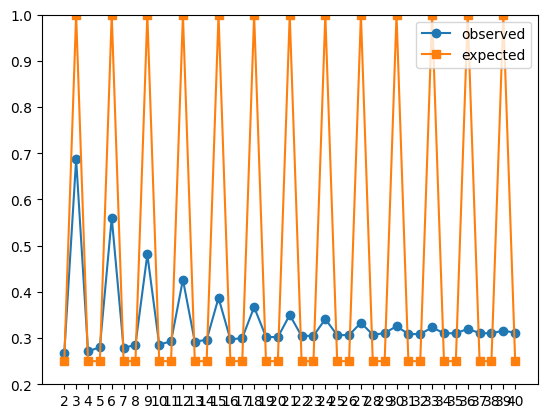

108 {'language': 'mod_3', 'key': 614, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 22, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.772584013010206
59.204153846153794


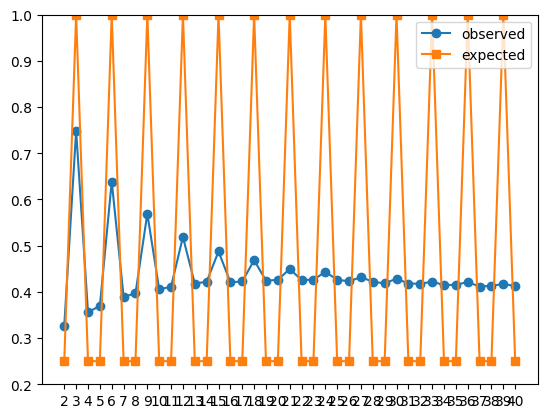

109 {'language': 'mod_3', 'key': 615, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 22, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8283045294341539
38.44684615384612


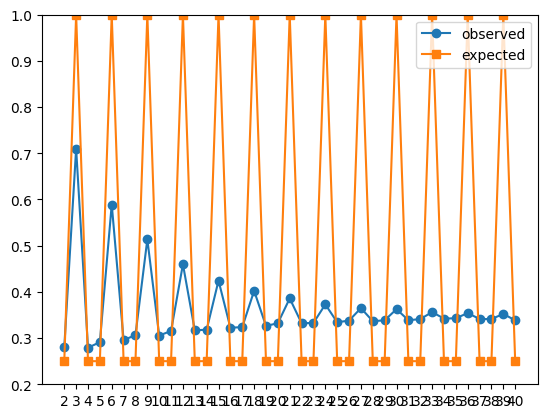

126 {'language': 'mod_3', 'key': 632, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 24, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.7623182970990082
63.94533333333329


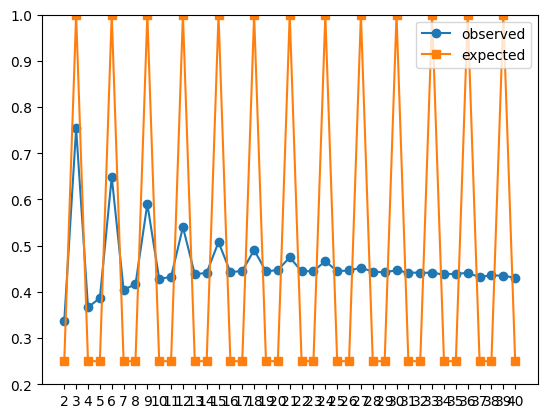

127 {'language': 'mod_3', 'key': 633, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 24, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8199874705915428
44.19758974358969


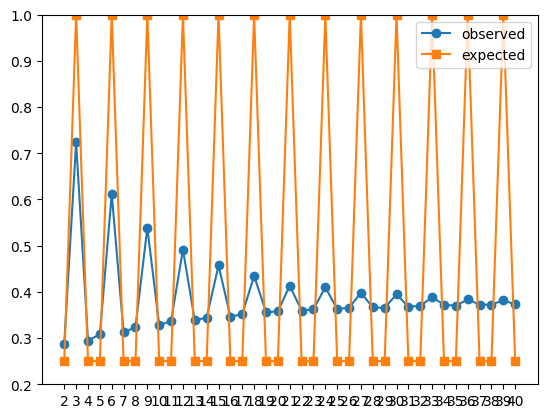

In [14]:
for i, (k, experiment) in enumerate(iterate_nested_dict(experiments)):
    # mod_3
    if k['language'] != 'mod_3':# or k['qfa size'] != 12:
        continue
    # if k['simulator']:
    #     continue
    # if k['language'] != 'singleton_3' or k['qfa size'] != 4:
    #     continue
    # if k['name']!='mapping effect, mimic rate change, union':
    #     continue
    if k['mimic_rate_gate']!=0.01 or k['mimic_rate_readout']!=0.01:
        continue
    # if k['use_entropy_mapping']:
    #     continue
    print(i, k)
    # k_ = k.copy()
    # k_['use_entropy_mapping'] = True
    # experiment2 = get_from_nested_dict(experiments, k_)
    # print(k_)
    draw_line_plot(experiment, False, (0.2,1))

0 {'language': 'mod_3', 'key': 506, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 10, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.9099438066010012


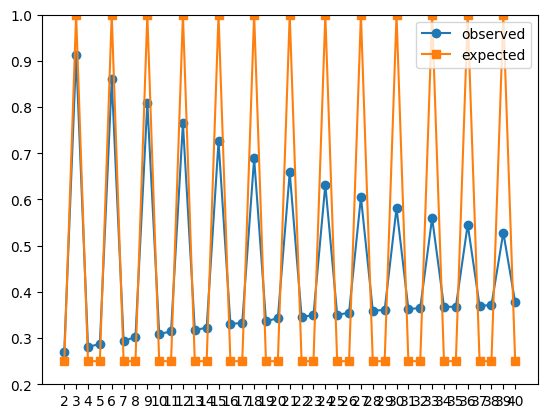

1 {'language': 'mod_3', 'key': 507, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 10, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.9227166593944333


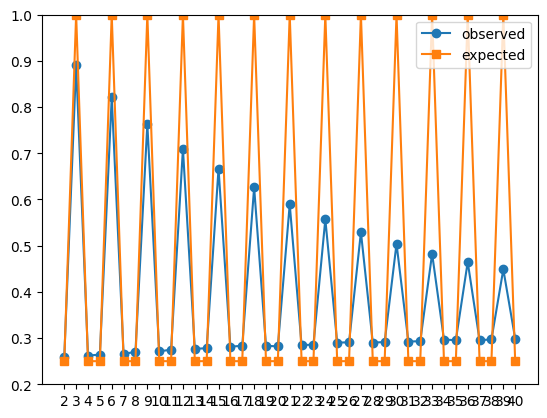

18 {'language': 'mod_3', 'key': 524, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 12, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.9050991057900426


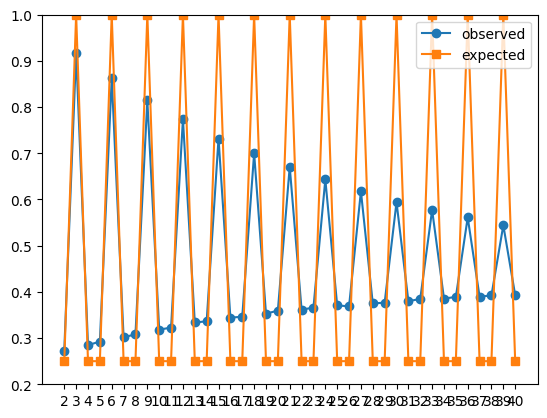

19 {'language': 'mod_3', 'key': 525, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 12, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.9188686427902533


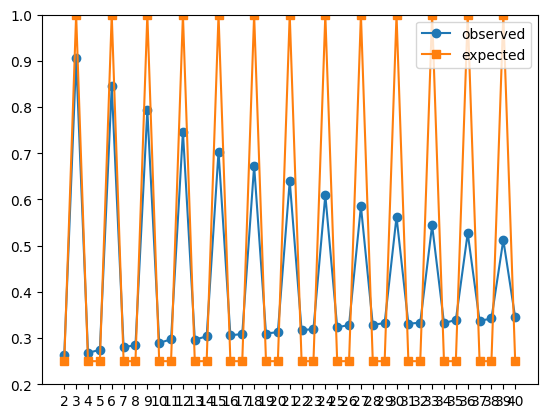

36 {'language': 'mod_3', 'key': 542, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 14, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.8907965412994278


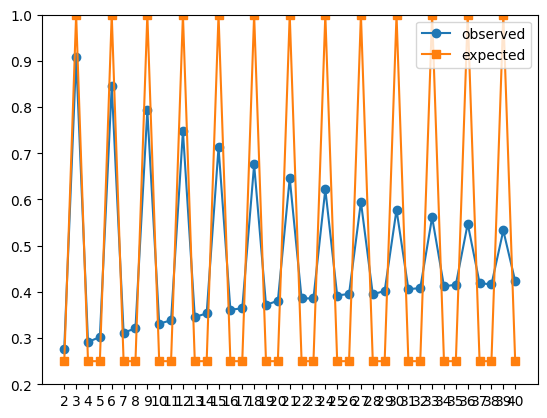

37 {'language': 'mod_3', 'key': 543, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 14, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.915889946844554


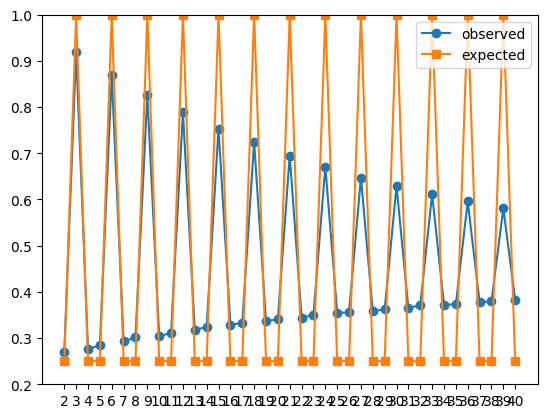

54 {'language': 'mod_3', 'key': 560, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 16, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.8830270013806472


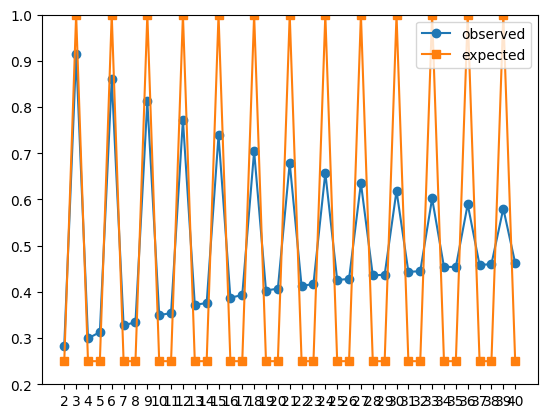

55 {'language': 'mod_3', 'key': 561, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 16, 'qiskit circuit size': 4, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.9202694180513094


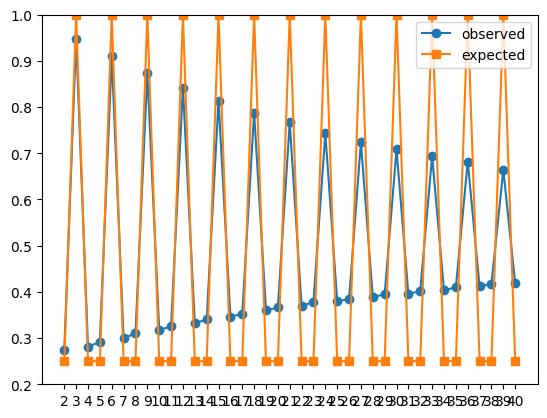

72 {'language': 'mod_3', 'key': 578, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.7863791021138508


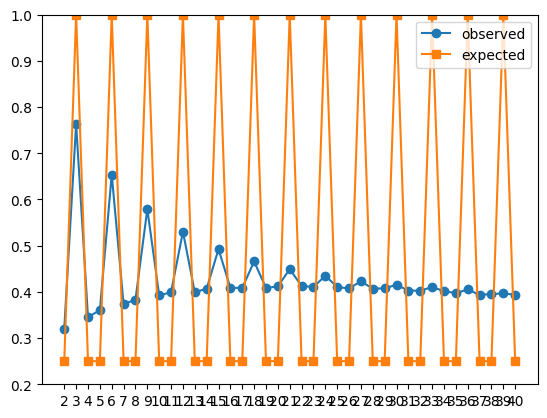

73 {'language': 'mod_3', 'key': 579, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 18, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8452140018035187


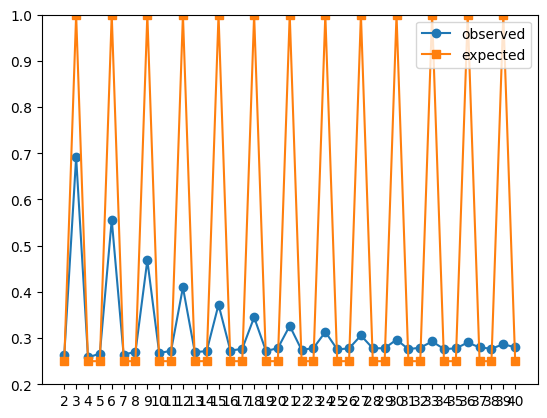

90 {'language': 'mod_3', 'key': 596, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 20, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.7858859609940039


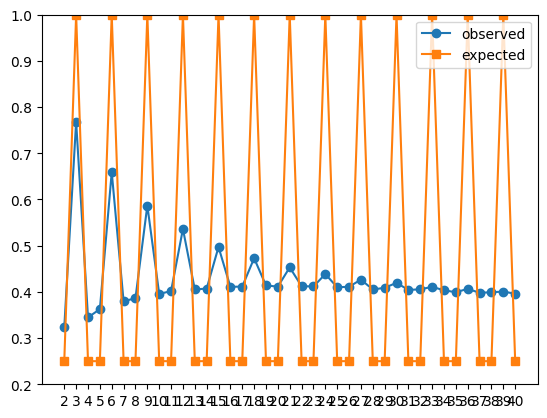

91 {'language': 'mod_3', 'key': 597, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 20, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8341693762162535


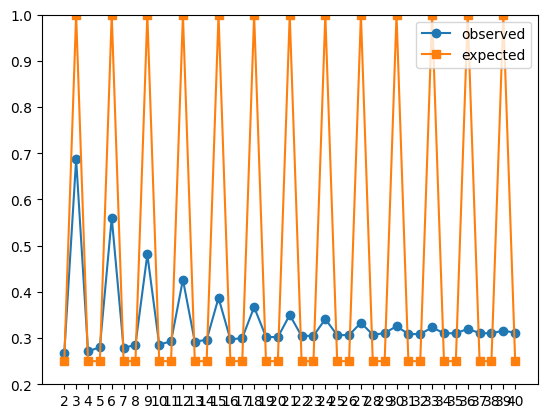

108 {'language': 'mod_3', 'key': 614, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 22, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.772584013010206


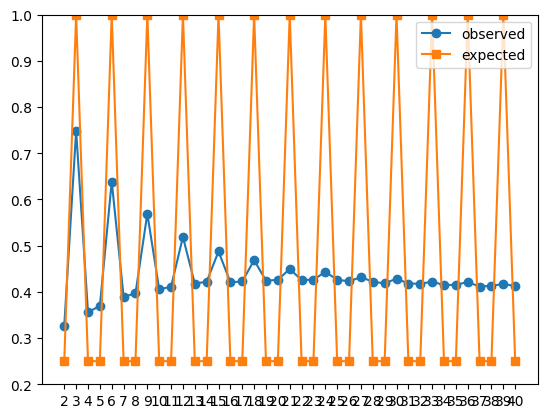

109 {'language': 'mod_3', 'key': 615, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 22, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8283045294341539


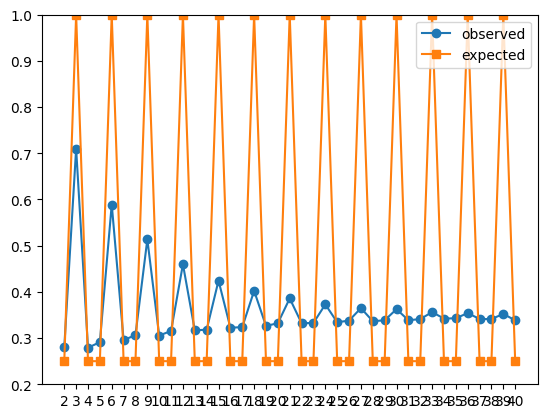

126 {'language': 'mod_3', 'key': 632, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 24, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': False, 'use_mapping_noise_correction': False}
0.7623182970990082


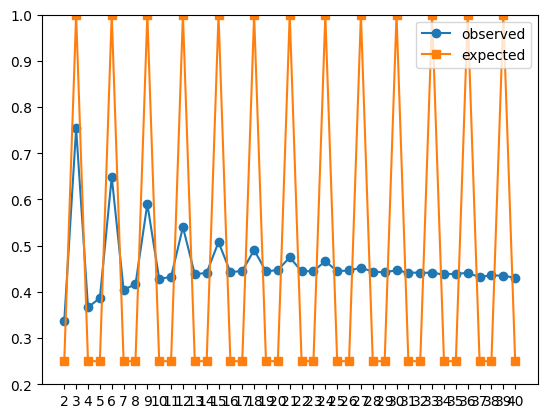

127 {'language': 'mod_3', 'key': 633, 'name': 'mapping effect, change QFA state number', 'shots': 100000, 'qfa size': 24, 'qiskit circuit size': 5, 'simulator': True, 'mimic_rate_gate': 0.01, 'mimic_rate_readout': 0.01, 'use_entropy_mapping': True, 'use_mapping_noise_correction': False}
0.8199874705915428


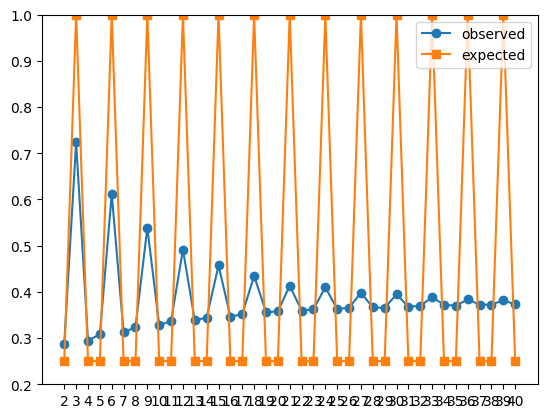

In [12]:
for i, (k, experiment) in enumerate(iterate_nested_dict(experiments)):
    # mod_3
    if k['language'] != 'mod_3':# or k['qfa size'] != 12:
        continue
    # if k['simulator']:
    #     continue
    # if k['language'] != 'singleton_3' or k['qfa size'] != 4:
    #     continue
    # if k['name']!='mapping effect, mimic rate change, union':
    #     continue
    if k['mimic_rate_gate']!=0.01 or k['mimic_rate_readout']!=0.01:
        continue
    # if k['use_entropy_mapping']:
    #     continue
    print(i, k)
    # k_ = k.copy()
    # k_['use_entropy_mapping'] = True
    # experiment2 = get_from_nested_dict(experiments, k_)
    # print(k_)
    draw_line_plot(experiment, False, (0.2,1))